In [1]:
import sys
import ast
import json
from rouge_score import rouge_scorer
from rouge_score import scoring
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from lexrank import STOPWORDS, LexRank
from transformers import AutoTokenizer

In [2]:
def to_paragraph(text):
    """
    converts text comprised of lists of sentances to a single to_paragraph

    text - list of multiple string sentances

    continuous_text - single continuous text string
    """
    continuous_text = ''
    for line in text:
        continuous_text += line
    return continuous_text

In [14]:
!ls ../data

create_mini_val_lexrank_csv.ipynb  mini_val_indexes.txt   ranked_data
doc_results.txt			   mini_val_set_json.txt  ranked_temporal_data
json_train.txt			   oldbindata		  raw_data


In [3]:
# read in validation data
with open('../data/json_test.txt') as json_file:
    test = json.load(json_file)
test = test['data']

In [8]:
documents = [i['article_text'] for i in test]
lxr = LexRank(documents, stopwords=STOPWORDS['en'])

In [9]:
# evaluate number of sentance on average in an abstract
abs_lens = [len(i['abstract_text']) for i in test]
abs_lens = np.array(abs_lens)
print(f'Mean number of sentances: {abs_lens.mean()}')
print(f'Std number of sentanges: {abs_lens.std()}')

Mean number of sentances: 6.92580354460799
Std number of sentanges: 2.957426639272754


In [11]:
#run lex rank summarization on full test set with a summarization length of 7 sentances
summaries_df = pd.DataFrame(columns=['reference', 'prediction'])
results = {}
#instantiate scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()
count = 0
for i in test:
    # generate summary and reference
    prediction = lxr.get_summary(sentences=i['article_text'], summary_size=7)
    reference = to_paragraph(i['abstract_text'])
    
    # score summary against reference
    #print(reference)
    score = scorer.score(reference, prediction[0])
    aggregator.add_scores(score)
    ag_score = aggregator.aggregate()
        
    # add score to dictionary
    results[i['article_id']] = score
    
    #add summary and reference to dataframe
    addition = pd.DataFrame([[to_paragraph(i['abstract_text']), prediction[0]]], columns=['reference', 'prediction'])
    summaries_df = summaries_df.append(addition, ignore_index=True)
    
    # print status
    if count % 100 == 0:
        print(f'generated {count} summaries.')
    count += 1
total_ag_score = ag_score
print('Completed summary generation.')
print(f'aggregate metrics:\n {total_ag_score}')
summaries_df.to_csv('../results/lexrank_results/lexrank_summaries.csv', index=False)
with open("../results/lexrank_results/lexrank_scores.txt", 'w') as outfile:
    json.dump(results, outfile)

generated 0 summaries.
generated 100 summaries.
generated 200 summaries.
generated 300 summaries.
generated 400 summaries.
generated 500 summaries.
generated 600 summaries.
generated 700 summaries.
generated 800 summaries.
generated 900 summaries.
generated 1000 summaries.
generated 1100 summaries.
generated 1200 summaries.
generated 1300 summaries.
generated 1400 summaries.
generated 1500 summaries.
generated 1600 summaries.
generated 1700 summaries.
generated 1800 summaries.
generated 1900 summaries.
generated 2000 summaries.
generated 2100 summaries.
generated 2200 summaries.
generated 2300 summaries.
generated 2400 summaries.
generated 2500 summaries.
generated 2600 summaries.
generated 2700 summaries.
generated 2800 summaries.
generated 2900 summaries.
generated 3000 summaries.
generated 3100 summaries.
generated 3200 summaries.
generated 3300 summaries.
generated 3400 summaries.
generated 3500 summaries.
generated 3600 summaries.
generated 3700 summaries.
generated 3800 summaries

In [12]:
# generate token lenghts for each document

token_lengths = {}
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
for i in test:
    token_lengths[i['article_id']] = len(tokenizer(i['article_text'],is_split_into_words=True, return_tensors='pt', truncation=False)[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (4769 > 4096). Running this sequence through the model will result in indexing errors


In [13]:
# load lexrank results into data frame
with open('../results/lexrank_results/lexrank_scores.txt') as json_file:
    results = json.load(json_file)
    
df = pd.DataFrame.from_dict(results, orient='index') # import data into pandas

# UDFs to unpack values
def unpack_f1(line, index=2):
    return line[index]
def unpack_precision(line, index=0):
    return line[index]
def unpack_recall(line, index=1):
    return line[index]
# UDF to get length
def get_length(article_id, token_lengths=token_lengths):
    return token_lengths[article_id]

# unpack values into individual columns
df['rouge_1_f1'] = df.rouge1.apply(unpack_f1)
df['rouge_1_recall'] = df.rouge1.apply(unpack_recall)
df['rouge_1_precision'] = df.rouge1.apply(unpack_precision)
df['rouge_2_f1'] = df.rouge2.apply(unpack_f1)
df['rouge_2_recall'] = df.rouge2.apply(unpack_recall)
df['rouge_2_precision'] = df.rouge2.apply(unpack_precision)
df['rouge_lsum_f1'] = df.rougeLsum.apply(unpack_f1)
df['rouge_lsum_recall'] = df.rougeLsum.apply(unpack_recall)
df['rouge_lsum_precision'] = df.rougeLsum.apply(unpack_precision)

# reset index and rename article id field
df.reset_index(inplace=True)
df.rename({'index':'article_id'},axis=1, inplace=True)
# add length
df['length'] = df.article_id.apply(get_length)
df.head()

,article_id,rouge1,rouge2,rougeLsum,rouge_1_f1,rouge_1_recall,rouge_1_precision,rouge_2_f1,rouge_2_recall,rouge_2_precision,rouge_lsum_f1,rouge_lsum_recall,rouge_lsum_precision,length
0,PMC5075302,"[0.7166666666666667, 0.22279792746113988, 0.33...","[0.3220338983050847, 0.09895833333333333, 0.15...","[0.35, 0.10880829015544041, 0.16600790513833993]",0.339921,0.222798,0.716667,0.151394,0.098958,0.322034,0.166008,0.108808,0.350000,3915
1,PMC3309138,"[0.5454545454545454, 0.24242424242424243, 0.33...","[0.23255813953488372, 0.10204081632653061, 0.1...","[0.36363636363636365, 0.16161616161616163, 0.2...",0.335664,0.242424,0.545455,0.141844,0.102041,0.232558,0.223776,0.161616,0.363636,3296
2,PMC4086000,"[0.4827586206896552, 0.056910569105691054, 0.1...","[0.10714285714285714, 0.012244897959183673, 0....","[0.3793103448275862, 0.044715447154471545, 0.0...",0.101818,0.056911,0.482759,0.021978,0.012245,0.107143,0.080000,0.044715,0.379310,4769
3,PMC3603086,"[0.5128205128205128, 0.13986013986013987, 0.21...","[0.21052631578947367, 0.056338028169014086, 0....","[0.28205128205128205, 0.07692307692307693, 0.1...",0.219780,0.139860,0.512821,0.088889,0.056338,0.210526,0.120879,0.076923,0.282051,1143
4,PMC4414990,"[0.7096774193548387, 0.21052631578947367, 0.32...","[0.21311475409836064, 0.0625, 0.0966542750929368]","[0.4838709677419355, 0.14354066985645933, 0.22...",0.324723,0.210526,0.709677,0.096654,0.062500,0.213115,0.221402,0.143541,0.483871,4399


m1: -2.1962147088015564e-06, m2: 8.942665298849623e-07, m3: 5.616877451806121e-07
m4: -4.526813740774876e-06, m5: -7.350966642029443e-07, m6: -1.2340696515231086e-06
m7: -3.6606015542162946e-06, m8: -5.7227203821137974e-08, m9: -5.201114211738345e-07


Rouge 1 f1 Mean: 0.23230692749972578
Rouge 2 f1 Mean: 0.07866791843813227
Rouge lsum f1 Mean: 0.15147168228282717


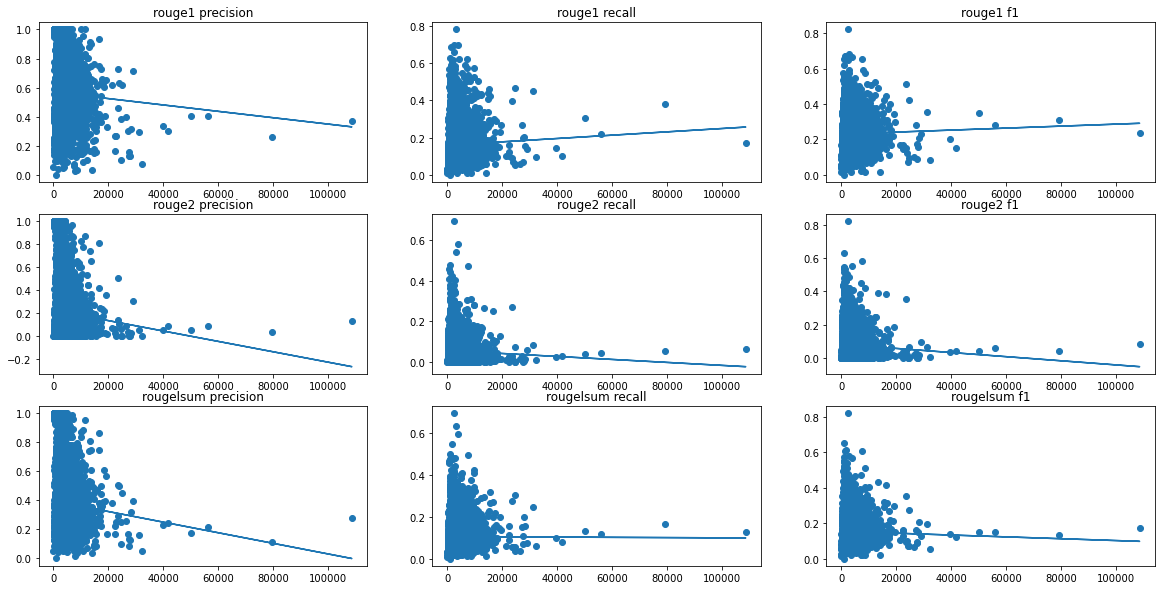

In [14]:
#df = df[df['length'] < 18000]
fig, axs = plt.subplots(3,3, figsize = (20,10))
axs[0,0].set_title('rouge1 precision')
axs[0,0].scatter(df.length, df.rouge_1_precision)
m1, b1 = np.polyfit(df.length, df.rouge_1_precision, 1)
axs[0,0].plot(df.length, m1*df.length + b1)
#rouge 1
axs[0,1].set_title('rouge1 recall')
axs[0,1].scatter(df.length, df.rouge_1_recall)
m2, b2 = np.polyfit(df.length, df.rouge_1_recall, 1)
axs[0,1].plot(df.length, m2*df.length + b2)

axs[0,2].set_title('rouge1 f1')
axs[0,2].scatter(df.length, df.rouge_1_f1)
m3, b3 = np.polyfit(df.length, df.rouge_1_f1, 1)
axs[0,2].plot(df.length, m3*df.length + b3)


# rouge 2
axs[1,0].set_title('rouge2 precision')
axs[1,0].scatter(df.length, df.rouge_2_precision)
m4, b4 = np.polyfit(df.length, df.rouge_2_precision, 1)
axs[1,0].plot(df.length, m4*df.length + b4)

axs[1,1].set_title('rouge2 recall')
axs[1,1].scatter(df.length, df.rouge_2_recall)
m5, b5 = np.polyfit(df.length, df.rouge_2_recall, 1)
axs[1,1].plot(df.length, m5*df.length + b5)

axs[1,2].set_title('rouge2 f1')
axs[1,2].scatter(df.length, df.rouge_2_f1)
m6, b6 = np.polyfit(df.length, df.rouge_2_f1, 1)
axs[1,2].plot(df.length, m6*df.length + b6)


# rouge lsum
axs[2,0].set_title('rougelsum precision')
axs[2,0].scatter(df.length, df.rouge_lsum_precision)
m7, b7 = np.polyfit(df.length, df.rouge_lsum_precision, 1)
axs[2,0].plot(df.length, m7*df.length + b7)

axs[2,1].set_title('rougelsum recall')
axs[2,1].scatter(df.length, df.rouge_lsum_recall)
m8, b8 = np.polyfit(df.length, df.rouge_lsum_recall, 1)
axs[2,1].plot(df.length, m8*df.length + b8)

axs[2,2].set_title('rougelsum f1')
axs[2,2].scatter(df.length, df.rouge_lsum_f1)
m9, b9 = np.polyfit(df.length, df.rouge_lsum_f1, 1)
axs[2,2].plot(df.length, m9*df.length + b9)

print(f'm1: {m1}, m2: {m2}, m3: {m3}')
print(f'm4: {m4}, m5: {m5}, m6: {m6}')
print(f'm7: {m7}, m8: {m8}, m9: {m9}')
print('\n')
print(f'Rouge 1 f1 Mean: {df.rouge_1_f1.mean()}')
print(f'Rouge 2 f1 Mean: {df.rouge_2_f1.mean()}')
print(f'Rouge lsum f1 Mean: {df.rouge_lsum_f1.mean()}')

In [15]:
print(f'Rouge 1 f1 Std: {df.rouge_1_f1.std()}')
print(f'Rouge 2 f1 Std: {df.rouge_2_f1.std()}')
print(f'Rouge lsum f1 Std: {df.rouge_lsum_f1.std()}')

Rouge 1 f1 Std: 0.09104550428304667
Rouge 2 f1 Std: 0.067906826464197
Rouge lsum f1 Std: 0.06771735203227343
